# Libraries

In [ ]:
pip install pyts

In [ ]:
pip install tqdm

In [ ]:
!nvidia-smi
from os import listdir
from os.path import isfile, join
import csv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from pyts.datasets import load_gunpoint
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPooling2D, Input, LeakyReLU, concatenate
from keras.optimizers import Adam
from collections import Counter
import tqdm
from keras.layers import LSTM, SimpleRNN, Bidirectional
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import optimizers

Wed Dec 23 19:25:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from keras.utils.vis_utils import plot_model

# datafiles

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
cd ..

/


In [ ]:
cd gdrive/MyDrive/DLPS_Project/

/gdrive/MyDrive/DLPS_Project


In [ ]:
def returnFileList(mypath):
  return [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [ ]:
batch_h = returnFileList('Healthy')
batch_f = returnFileList('BrokenTooth')

In [ ]:
def convertfile(batchfile, path):
 
  target = []
  label = []

  for file in batchfile: 
    with open(path + file) as csv_file:
      s1 = []
      s2 = []
      s3 = [] 
      s4 = []
      line = 0
      csv_reader = csv.reader(csv_file, delimiter = ',')
      next(csv_reader)
      
      for row in csv_reader:
        if line < 80000:
          s1.append(float(row[0]))
          s2.append(float(row[1]))
          s3.append(float(row[2]))
          s4.append(float(row[3]))
          line = line + 1
      target.append(np.vstack(( np.array(s1), np.array(s2), np.array(s3), np.array(s4) )))
      if file[0] == 'b':
        label.append(1)
      else: 
        label.append(0)
  return np.array(target), np.array(label)

In [ ]:
target_0, label_0 = convertfile(returnFileList('Healthy'), 'Healthy/')
target_1, label_1 = convertfile(returnFileList('BrokenTooth'), 'BrokenTooth/')

In [ ]:
target = np.vstack((target_0, target_1))
n, s, t = target.shape
target = target.reshape((n, t, s))

label = np.hstack((label_0, label_1))

In [ ]:
print(target_0.shape)
print(target_1.shape)
print(label_0.shape)
print(label_1.shape)
print(target.shape)
print(label.shape)

(10, 4, 80000)
(10, 4, 80000)
(10,)
(10,)
(20, 80000, 4)
(20,)


In [ ]:
target = np.hsplit(target, 80)
target = np.vstack(target)
print(target.shape)

(1600, 1000, 4)


In [ ]:
label = []
for i in range(0, 1600):
  if i < 800:
    label.append(0)
  else:
    label.append(1)
label = np.array(label)

In [ ]:
print(target_0.shape)
print(target_1.shape)
print(label_0.shape)
print(label_1.shape)
print(target.shape)
print(label.shape)

(10, 4, 80000)
(10, 4, 80000)
(10,)
(10,)
(1600, 1000, 4)
(1600,)


# LSTM/ CNN Data


## Gramin Field Data

In [ ]:
def getGADFdata_(Df):
  X = []
  y = []
  gadf = GramianAngularField(image_size=128, method='difference')

  for t in [0, 1]:
    for l in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]:
      data = []
      for x in [1, 2, 3, 4]:
        p = df[(df['load'] == l) & (df['target'] == t)].iloc[:, x].to_numpy()
        p = gadf.fit_transform(np.expand_dims(p, 0))
        data.append(np.squeeze(p))
      X.append(data)
      y.append(t)

  return np.array(X), np.array(y)


def getGADFdata(sensData):
  ## GADF data
  #X_gadf = []
  gadf = GramianAngularField(image_size=128, method='difference')
  for x in sensData:
    print(x.shape)
    y = np.array(gadf.fit_transform(x))
    X_gadf.append(y)
  X_gadf = np.array(X_gadf)
  print(X_gadf.shape)
  X_gadf = np.expand_dims(X_gadf, axis = 1)
  print(X_gadf.shape)

  return np.array(X_gadf)

In [ ]:
# Show the images for the first time series
fig = plt.figure(figsize=(7,7))
grid = ImageGrid(fig, 111, nrows_ncols = (3, 3), axes_pad=0.15, share_all=True, cbar_location="right", cbar_mode="single", cbar_size="7%", cbar_pad=0.3)

images = [x for x in X_gadf]
for image, ax in zip(images, grid):
    im = ax.imshow(image, cmap='rainbow', origin='lower')
    
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.suptitle('Gramian Angular Fields', y=0.98, fontsize=16)
plt.show()

## Spectogram Data

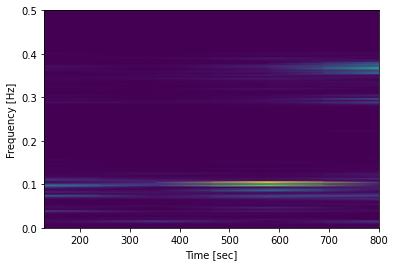

In [ ]:
freq = []
time = []
X_sptg = []
for x in sensors_data:
  f, t, Sxx = signal.spectrogram(x)
  freq.append(f)
  time.append(t)
  X_sptg.append(Sxx)

X_sptg = np.array(X_sptg)

plt.pcolormesh(time[0], freq[0], X_sptg[0], shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
print(X_sptg.shape)
X_sptg = np.expand_dims(X_sptg, axis = 3)
print(X_sptg.shape)

(8000, 129, 4)
(8000, 129, 4, 1)


# CNN 

## Gramin DataField


### Data - GADF

In [ ]:
def getGADFdata(sensData):                                            ### (num_samples, time_seq, sensors)
  ## GADF data
  gadf = GramianAngularField(image_size=256, method='difference')
  s1 = np.array(gadf.fit_transform(sensData[:, :, 0]))
  s2 = np.array(gadf.fit_transform(sensData[:, :, 1]))
  s3 = np.array(gadf.fit_transform(sensData[:, :, 2]))
  s4 = np.array(gadf.fit_transform(sensData[:, :, 3]))
  X_gadf = np.stack((s1, s2, s3, s4), axis = 3)
  print(X_gadf.shape)
  #X_gadf = np.expand_dims(X_gadf, axis = 1)
  #print(X_gadf.shape)

  return X_gadf

In [ ]:
x_gadf = getGADFdata(target)

(1600, 256, 256, 4)


### Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_gadf, label, test_size=0.1, random_state=42)

In [ ]:
Counter(y_train)

Counter({0: 707, 1: 733})

In [ ]:
#Define Model
model4 = Sequential()

model4.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 4)))
model4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model4.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model4.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))

model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dense(16, activation='relu'))

model4.add(Dense(1, activation='sigmoid'))

#Compile
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model4.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 254, 254, 64)      2368      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 124, 124, 128)     73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 122, 122, 128)     147584    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 59, 59, 256)       2

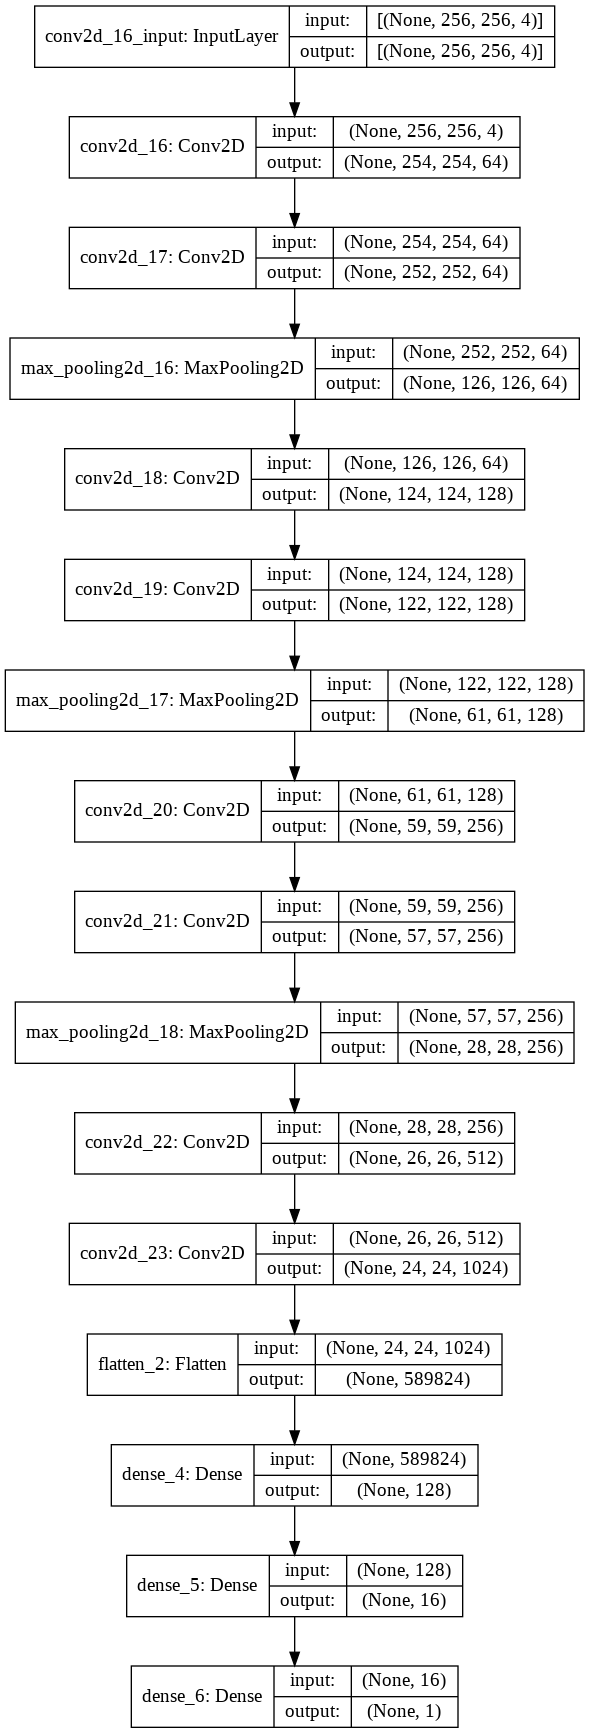

In [ ]:
plot_model(model4, to_file='CNN_GADF_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Train and Test The Model
model4.fit(X_train, y_train, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
36/36 [==============================] - 32s 573ms/step - loss: 1.3898 - accuracy: 0.5247 - val_loss: 0.6942 - val_accuracy: 0.4722
Epoch 2/10
36/36 [==============================] - 20s 556ms/step - loss: 0.6945 - accuracy: 0.4791 - val_loss: 0.6934 - val_accuracy: 0.4722
Epoch 3/10
36/36 [==============================] - 20s 556ms/step - loss: 0.6933 - accuracy: 0.4832 - val_loss: 0.6931 - val_accuracy: 0.5278
Epoch 4/10
36/36 [==============================] - 20s 556ms/step - loss: 0.6934 - accuracy: 0.5067 - val_loss: 0.6931 - val_accuracy: 0.5278
Epoch 5/10
36/36 [==============================] - 20s 556ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5278
Epoch 6/10
36/36 [==============================] - 20s 554ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6930 - val_accuracy: 0.5278
Epoch 7/10
36/36 [==============================] - 20s 556ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6930 - val_accuracy: 0.5278

## Spectrogram


### Data - Spec

In [ ]:
cd images/

/gdrive/MyDrive/DLPS_Project/images


In [ ]:
def getSpectdata(sens):                                            ### (num_samples, time_seq, sensors)
  ## spectrogram data
  a, b, c = sens.shape
  for i in range(943, a):
    f, t, Sxx = signal.spectrogram(sens[i, :, 0])
    plt.figure(frameon=False)
    plt.interactive(False)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    file_name = str(i) + '_' + '0.png'
    plt.axis('off')
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0)


    f, t, Sxx = signal.spectrogram(sens[i, :, 1])
    plt.figure(frameon=False)
    plt.interactive(False)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    file_name = str(i) + '_' + '1.png'
    plt.axis('off')
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0)

    f, t, Sxx = signal.spectrogram(sens[i, :, 2])
    plt.figure(frameon=False)
    plt.interactive(False)    
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    file_name = str(i) + '_' + '2.png'
    plt.axis('off')
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0)

    f, t, Sxx = signal.spectrogram(sens[i, :, 3])
    plt.figure(frameon=False)
    plt.interactive(False)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    file_name = str(i) + '_' + '3.png'
    plt.axis('off')
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0)

In [ ]:
getSpectdata(target)

In [ ]:
cd ..

/gdrive/My Drive/DLPS_Project


In [ ]:
ls

0_0.png  0_2.png  BrokenTooth/  image_data.npy  Papers/
0_1.png  0_3.png  Healthy/      images/


In [ ]:
image_files = os.listdir('images')
# input image dimensions
img_rows, img_cols = 200, 200

def returnSensorImg(image_files, cat):
  # input image dimensions
  img_rows, img_cols = 200, 200
  data = []

  for img in image_files:
    p = img.split('_')
    if p[1][0] == cat:
      img_read = load_img('images/' + img, target_size = (img_rows, img_cols))
      img_array = img_to_array(img_read)
      img_array = img_array/255
      data.append(np.array(img_array))
  image_data = np.array(data)
  return data

In [ ]:
del x_train_s1, x_train_s2, x_train_s3, x_train_s4

In [ ]:
x_train_s1 = returnSensorImg(image_files, '0')
x_train_s2 = returnSensorImg(image_files, '1')
x_train_s3 = returnSensorImg(image_files, '2')
x_train_s4 = returnSensorImg(image_files, '3')
x_train_comp = np.stack((x_train_s1, x_train_s2, x_train_s3, x_train_s4), axis=4)

In [ ]:
np.save('image_data.npy', x_train_comp)

In [ ]:
x_train_comp = np.load('image_data.npy')

### Model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train_comp, label, test_size = 0.1, random_state=42)

In [ ]:
Counter(y_train)

Counter({0: 719, 1: 721})

In [ ]:
x_train_s1 = x_train[:,:,:,:,0]
x_test_s1 = x_test[:,:,:,:,0]

x_train_s2 = x_train[:,:,:,:,1]
x_test_s2 = x_test[:,:,:,:,1]

x_train_s3 = x_train[:,:,:,:,2]
x_test_s3 = x_test[:,:,:,:,2]

x_train_s4 = x_train[:,:,:,:,3]
x_test_s4 = x_test[:,:,:,:,3]

In [ ]:
img_rows, img_cols = 200, 200
batch_size = 32
epochs = 10
input_shape = (img_rows, img_cols, 3)
input_img = Input(shape = input_shape)

def create_convolution_layers(input_img):
  model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2),padding='same')(model)
  
  model = Conv2D(64, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    
  return model

In [ ]:
s1_input = Input(shape=input_shape)
s1_model = create_convolution_layers(s1_input)

s2_input = Input(shape=input_shape)
s2_model = create_convolution_layers(s2_input)

s3_input = Input(shape=input_shape)
s3_model = create_convolution_layers(s3_input)

s4_input = Input(shape=input_shape)
s4_model = create_convolution_layers(s4_input)

conv = concatenate([s1_model, s2_model, s3_model, s4_model])

conv = Flatten()(conv)

dense = Dense(16)(conv)
dense = LeakyReLU(alpha=0.1)(dense)

output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[s1_input, s2_input, s3_input, s4_input], outputs=[output])

opt = optimizers.Adam()

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 200, 200, 3) 0                                            
____________________________________________________________________________________________

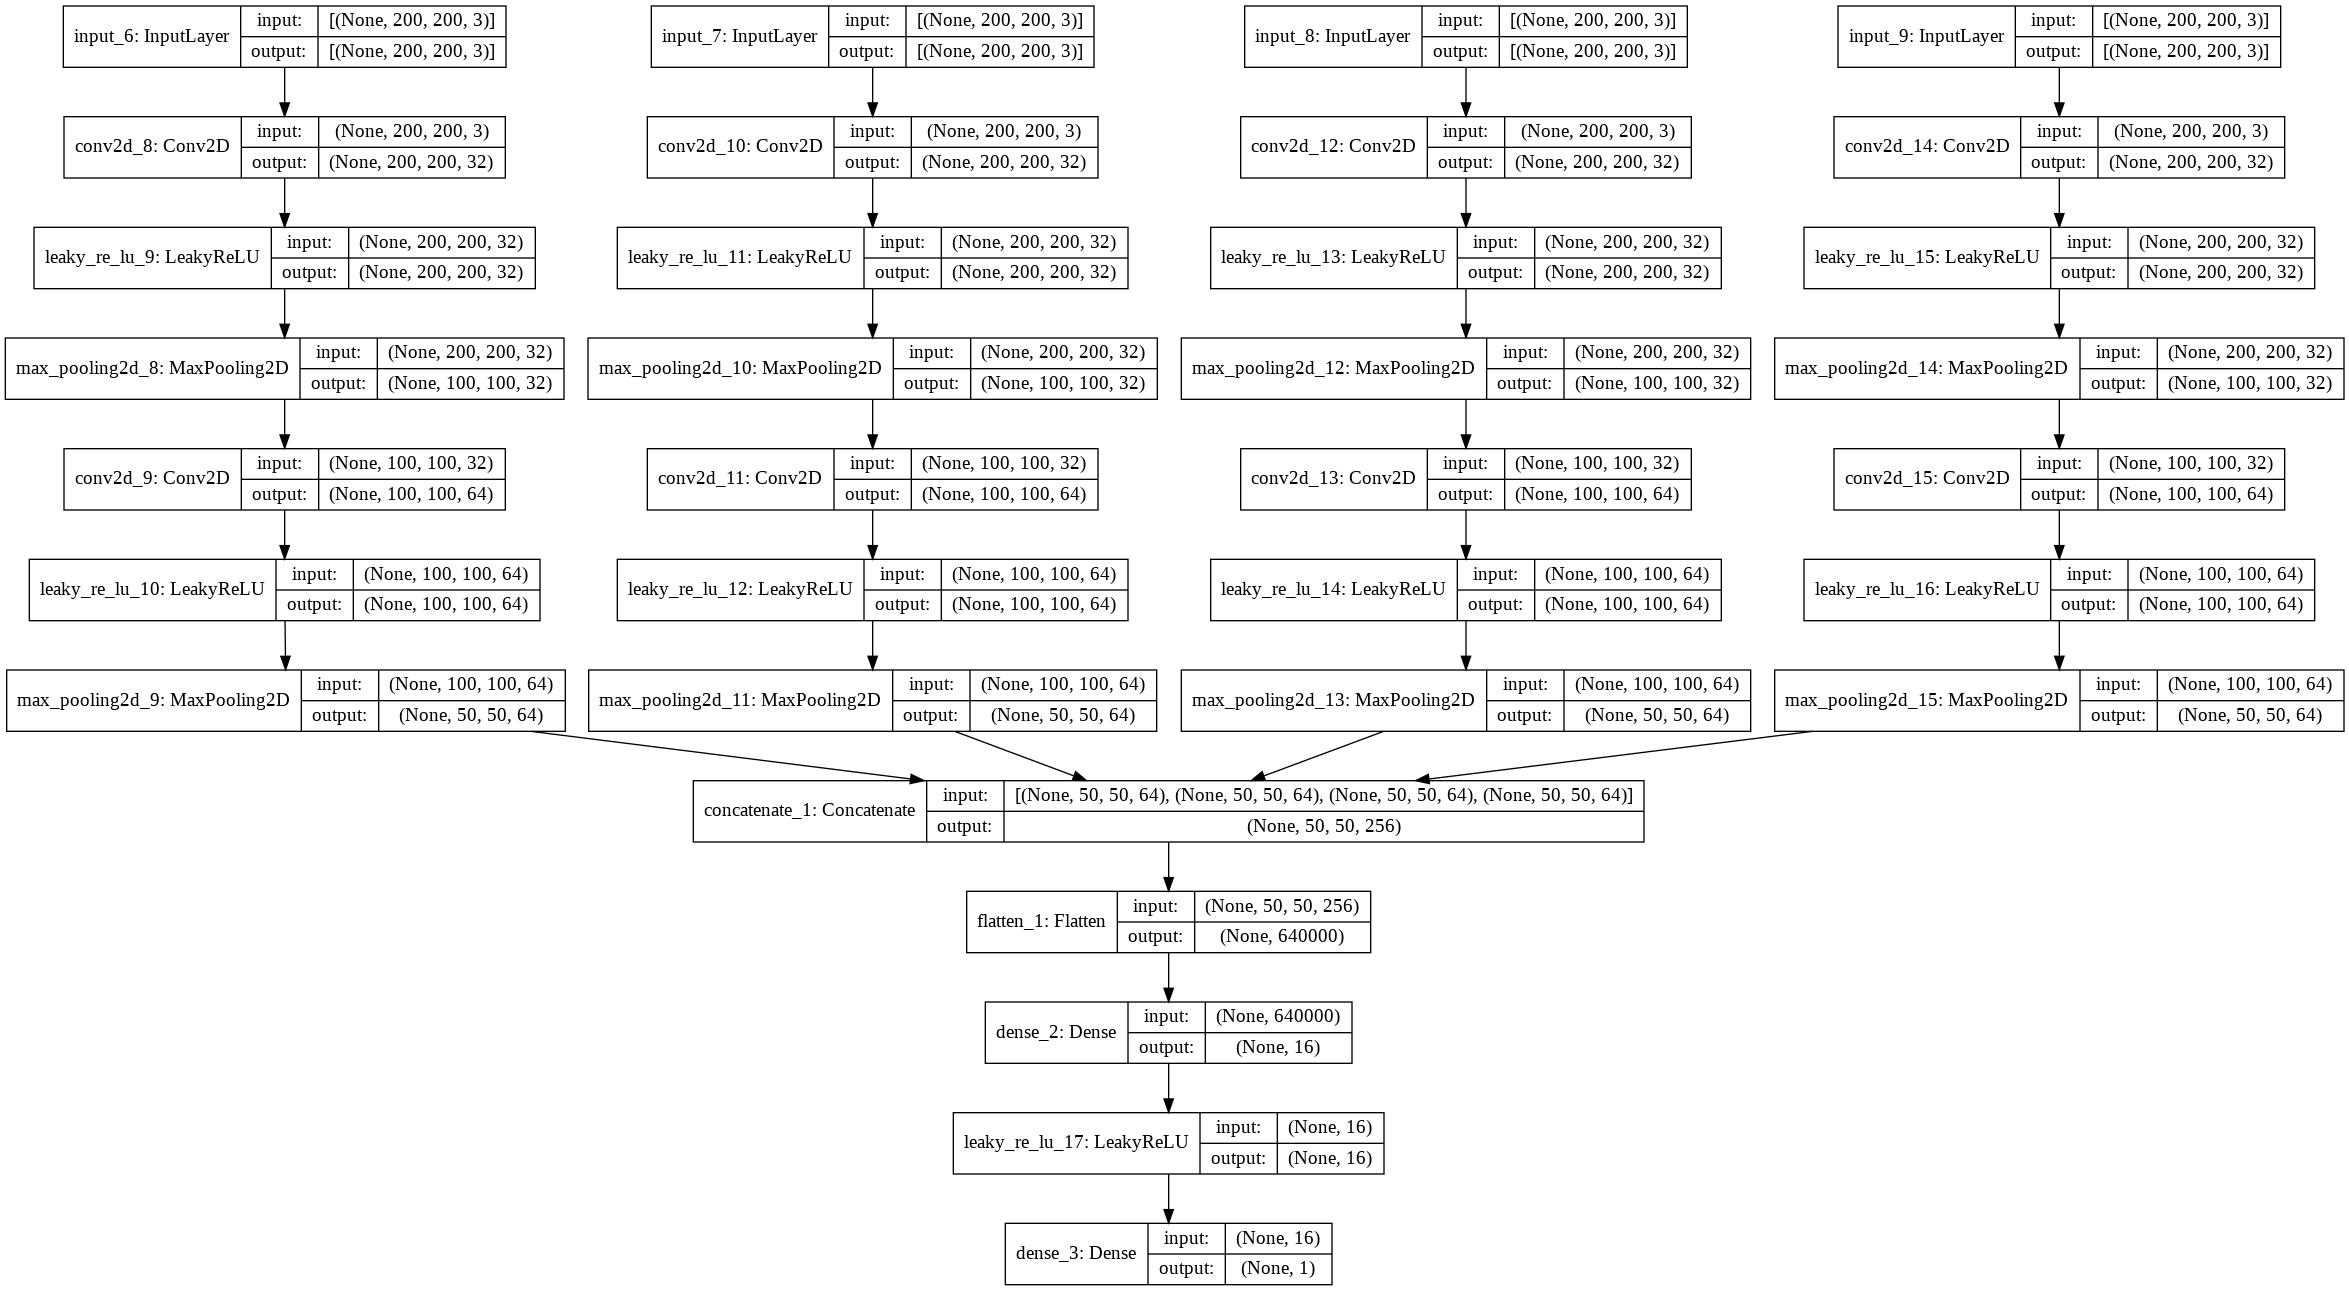

In [ ]:
plot_model(model, to_file='CNN_Spec_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history5 = model.fit([x_train_s1, x_train_s2, x_train_s3, x_train_s4], y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/10
45/45 [==============================] - 17s 203ms/step - loss: 2.9332 - accuracy: 0.6007
Epoch 2/10
45/45 [==============================] - 9s 203ms/step - loss: 0.0593 - accuracy: 0.9861
Epoch 3/10
45/45 [==============================] - 9s 204ms/step - loss: 0.0385 - accuracy: 0.9950
Epoch 4/10
45/45 [==============================] - 9s 202ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 5/10
45/45 [==============================] - 9s 205ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 6/10
45/45 [==============================] - 9s 204ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 7/10
45/45 [==============================] - 9s 204ms/step - loss: 7.9207e-04 - accuracy: 1.0000
Epoch 8/10
45/45 [==============================] - 9s 204ms/step - loss: 6.4394e-04 - accuracy: 1.0000
Epoch 9/10
45/45 [==============================] - 9s 203ms/step - loss: 6.0749e-04 - accuracy: 1.0000
Epoch 10/10
45/45 [==============================] - 9s 204ms/step - loss: 3.8231e-04 -

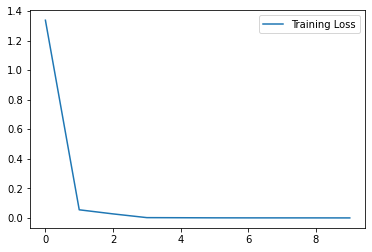

In [ ]:
#Plotting training and validation losses

# Losses clearly decreases over time

plt.plot(history5.history['loss'], label = "Training Loss")
plt.legend()

In [ ]:
results_cosLSTM = model.evaluate([x_test_s1, x_test_s2, x_test_s3, x_test_s4], y_test)

5/5 [==============================] - 1s 89ms/step - loss: 0.0075 - accuracy: 0.9937


# LSTM (55% acc)

In [ ]:
label_cos = []
for i in range(0, 1600):
  if i < 800:
    label_cos.append(float(0))
  else:
    label_cos.append(float(1))
label_cos = np.array(label_cos)

In [ ]:
xc_train, xc_test, yc_train, yc_test = train_test_split(target, label_cos, test_size = 0.1, random_state = 4)

In [ ]:
print(Counter(yc_train))
print(Counter(yc_test))

Counter({1.0: 722, 0.0: 718})
Counter({0.0: 82, 1.0: 78})


In [ ]:
# Programming a sequuential model with three LSTM units and dropout functions

model3 = Sequential()
model3.add(LSTM(100, return_sequences=True, batch_input_shape = (None, 1000, 4)))
model3.add(LSTM(50, return_sequences=True))
model3.add(LSTM(30, return_sequences=False))                        
model3.add(Dense(30, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))                     #return_sequences is set to 'False' to mark end of LSTM layer 
model3.compile(loss = 'cosine_similarity',  optimizer = 'adam', metrics = ['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1000, 100)         42000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 50)          30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_7 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 82,881
Trainable params: 82,881
Non-trainable params: 0
_________________________________________________________________


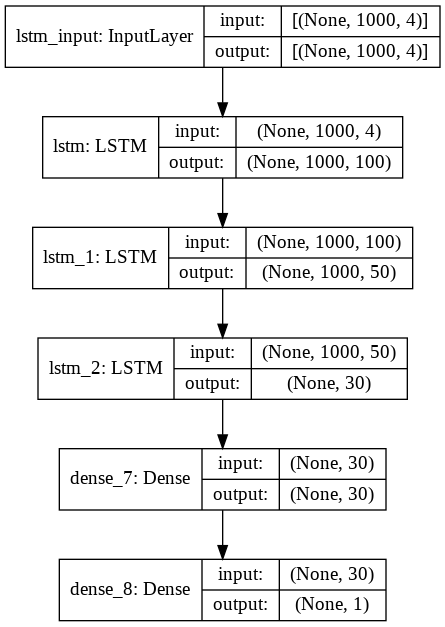

In [ ]:
plot_model(model3, to_file='lstm_cosine_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history3 = model3.fit(xc_train, yc_train, epochs = 20, verbose = 1, validation_split=0.2)

Epoch 1/20
36/36 [==============================] - 9s 179ms/step - loss: -0.5068 - accuracy: 0.5182 - val_loss: -0.5139 - val_accuracy: 0.4757
Epoch 2/20
36/36 [==============================] - 5s 153ms/step - loss: -0.4879 - accuracy: 0.5001 - val_loss: -0.5139 - val_accuracy: 0.4757
Epoch 3/20
36/36 [==============================] - 5s 151ms/step - loss: -0.5277 - accuracy: 0.5045 - val_loss: -0.5139 - val_accuracy: 0.4757
Epoch 4/20
36/36 [==============================] - 5s 150ms/step - loss: -0.5099 - accuracy: 0.5025 - val_loss: -0.5139 - val_accuracy: 0.4792
Epoch 5/20
36/36 [==============================] - 6s 155ms/step - loss: -0.4911 - accuracy: 0.5212 - val_loss: -0.5139 - val_accuracy: 0.4861
Epoch 6/20
36/36 [==============================] - 5s 152ms/step - loss: -0.4840 - accuracy: 0.5384 - val_loss: -0.5139 - val_accuracy: 0.4965
Epoch 7/20
36/36 [==============================] - 5s 147ms/step - loss: -0.5001 - accuracy: 0.5151 - val_loss: -0.5139 - val_accuracy:

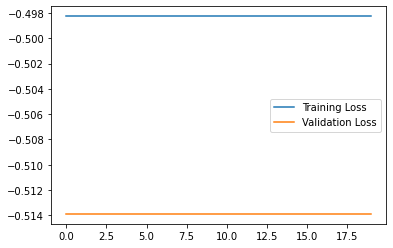

In [ ]:
#Plotting training and validation losses

# Losses clearly decreases over time

plt.plot(history3.history['loss'], label = "Training Loss")
plt.plot(history3.history['val_loss'], label = "Validation Loss")
plt.legend()

In [ ]:
results_cosLSTM = model.evaluate(xc_test, yc_test)

5/5 [==============================] - 2s 73ms/step - loss: 0.6949 - accuracy: 0.4944


# LSTM (99.76% acc)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(target, label, test_size = 0.1, random_state = 4)

In [ ]:
print(Counter(y_train))
print(Counter(y_test))

Counter({1: 722, 0: 718})
Counter({0: 82, 1: 78})


In [ ]:
# Programming a sequuential model with three LSTM units and dropout functions

model2 = Sequential()
model2.add(LSTM(100, return_sequences=True, batch_input_shape = (None, 1000, 4)))
model2.add(LSTM(50, return_sequences=True))
model2.add(LSTM(30, return_sequences=False))                        
model2.add(Dense(30, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))                     #return_sequences is set to 'False' to mark end of LSTM layer 
model2.compile(loss = 'binary_crossentropy',  optimizer = 'adam', metrics = ['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1000, 100)         42000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000, 50)          30200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense_9 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 31        
Total params: 82,881
Trainable params: 82,881
Non-trainable params: 0
_________________________________________________________________


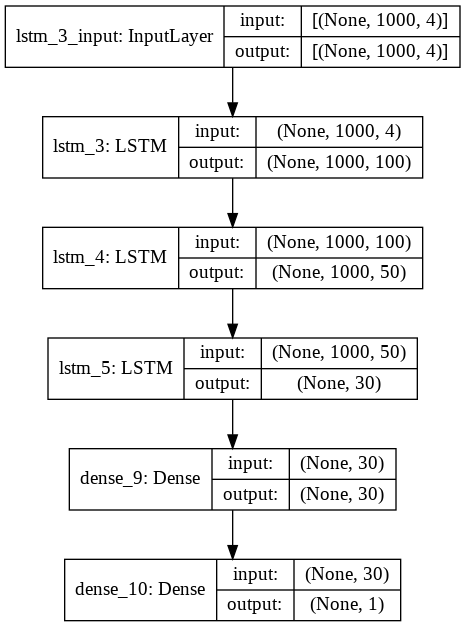

In [ ]:
plot_model(model2, to_file='LSTM_normal_loss_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history2 = model2.fit(x_train, y_train, epochs = 20, verbose = 1, validation_split=0.2)

Epoch 1/20
36/36 [==============================] - 10s 179ms/step - loss: 0.6343 - accuracy: 0.6324 - val_loss: 0.3635 - val_accuracy: 0.8715
Epoch 2/20
36/36 [==============================] - 6s 156ms/step - loss: 0.3475 - accuracy: 0.8811 - val_loss: 0.3483 - val_accuracy: 0.8750
Epoch 3/20
36/36 [==============================] - 6s 156ms/step - loss: 0.4597 - accuracy: 0.8204 - val_loss: 0.4191 - val_accuracy: 0.8264
Epoch 4/20
36/36 [==============================] - 6s 156ms/step - loss: 0.3725 - accuracy: 0.8406 - val_loss: 0.5472 - val_accuracy: 0.7257
Epoch 5/20
36/36 [==============================] - 6s 155ms/step - loss: 0.4747 - accuracy: 0.7825 - val_loss: 0.4366 - val_accuracy: 0.8611
Epoch 6/20
36/36 [==============================] - 6s 160ms/step - loss: 0.2508 - accuracy: 0.8987 - val_loss: 0.2637 - val_accuracy: 0.9028
Epoch 7/20
36/36 [==============================] - 5s 152ms/step - loss: 0.2493 - accuracy: 0.9034 - val_loss: 0.1267 - val_accuracy: 0.9653
Epoch

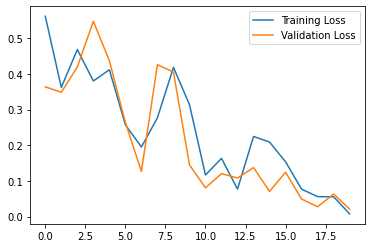

In [ ]:
#Plotting training and validation losses

# Losses clearly decreases over time

plt.plot(history2.history['loss'], label = "Training Loss")
plt.plot(history2.history['val_loss'], label = "Validation Loss")
plt.legend()

In [ ]:
results_LSTM = model2.evaluate(x_test, y_test)

5/5 [==============================] - 0s 52ms/step - loss: 0.0069 - accuracy: 1.0000


# BiLSTM (100% acc)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(target, label, test_size = 0.1, random_state = 4)

In [ ]:
print(Counter(y_train))
print(Counter(y_test))

Counter({1: 722, 0: 718})
Counter({0: 82, 1: 78})


In [ ]:
# Programming a sequuential model with three LSTM units and dropout functions

model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True), batch_input_shape = (None, 1000, 4)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(30, return_sequences=False)))                        
model.add(Dense(30, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))                     #return_sequences is set to 'False' to mark end of LSTM layer 
model.compile(loss = 'binary_crossentropy',  optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1000, 200)         84000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 100)         100400    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60)                31440     
_________________________________________________________________
dense_11 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 31        
Total params: 217,701
Trainable params: 217,701
Non-trainable params: 0
_________________________________________________________________


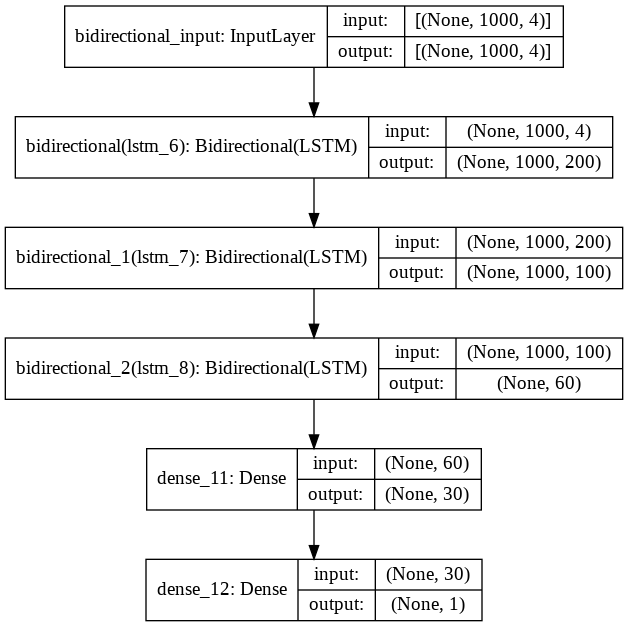

In [ ]:
plot_model(model, to_file='bilstm_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(x_train, y_train, epochs = 25, verbose = 1, validation_split=0.2)

Epoch 1/25
36/36 [==============================] - 12s 336ms/step - loss: 0.2693 - accuracy: 0.9036 - val_loss: 0.2206 - val_accuracy: 0.9167
Epoch 2/25
36/36 [==============================] - 12s 337ms/step - loss: 0.1869 - accuracy: 0.9323 - val_loss: 0.1351 - val_accuracy: 0.9549
Epoch 3/25
36/36 [==============================] - 12s 334ms/step - loss: 0.1328 - accuracy: 0.9566 - val_loss: 0.1245 - val_accuracy: 0.9514
Epoch 4/25
36/36 [==============================] - 12s 335ms/step - loss: 0.0894 - accuracy: 0.9679 - val_loss: 0.0735 - val_accuracy: 0.9792
Epoch 5/25
36/36 [==============================] - 12s 333ms/step - loss: 0.0685 - accuracy: 0.9800 - val_loss: 0.0458 - val_accuracy: 0.9826
Epoch 6/25
36/36 [==============================] - 12s 336ms/step - loss: 0.0576 - accuracy: 0.9792 - val_loss: 0.0456 - val_accuracy: 0.9861
Epoch 7/25
36/36 [==============================] - 12s 334ms/step - loss: 0.0507 - accuracy: 0.9861 - val_loss: 0.0338 - val_accuracy: 0.9931

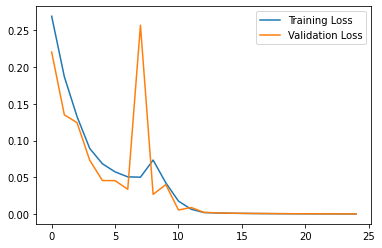

In [ ]:
#Plotting training and validation losses

# Losses clearly decreases over time

plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()

In [ ]:
results_biLSTM = model.evaluate(x_test, y_test)

5/5 [==============================] - 1s 138ms/step - loss: 2.5427e-04 - accuracy: 1.0000
